In [ ]:
!pip install yfinance ta --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from ta.momentum import RSIIndicator


  Preparing metadata (setup.py) ... done


In [ ]:
end_date = datetime.today().strftime('%Y-%m-%d')
stock_data = yf.download('AAPL', start='2015-01-01', end=end_date)
data = stock_data.reset_index()['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


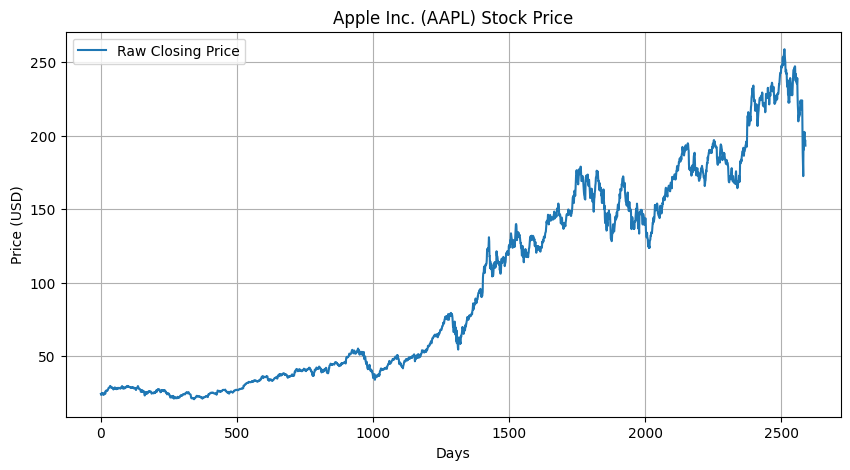

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data, label="Raw Closing Price")
plt.title("Apple Inc. (AAPL) Stock Price")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [ ]:
training_size = int(len(data) * 0.65)
train_data = data[:training_size]
test_data = data[training_size:]


In [ ]:
def create_dataset(dataset, time_step=100):
    dataX, dataY = [], [] #input sequences and output sequences
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
#reshaped into 3D arrays of shape (samples, 100 days, 1 feature) for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
          batch_size=64, verbose=1)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - loss: 0.0159 - val_loss: 0.0032
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 6.0212e-04 - val_loss: 0.0017
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 2.3146e-04 - val_loss: 0.0019
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 2.1743e-04 - val_loss: 0.0022
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 2.3217e-04 - val_loss: 0.0020
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 2.3940e-04 - val_loss: 0.0024
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 2.0022e-04 - val_loss: 0.0022
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 2.1357e-04 - val_loss: 0.0031
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 2.0413e-04 - val_loss: 0.0029
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 2.0576e-04 - val_loss: 0.0025
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 2.0398e-04 - val_loss: 0.0026

In [ ]:
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


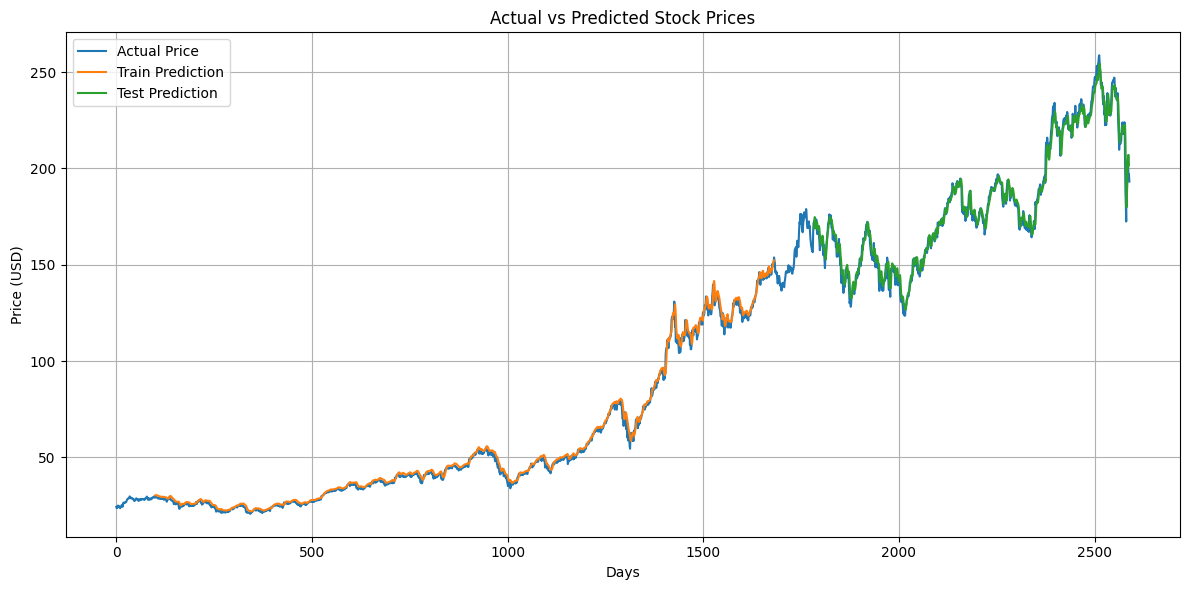

In [ ]:
look_back = 100
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(data) - 1, :]
= test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data), label='Actual Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
temp_input = test_data[341:].reshape(1, -1)[0].tolist()
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:]).reshape(1, -1, 1)
    else:
        x_input = np.pad(temp_input, (0, 100 - len(temp_input)), 'constant')
        x_input = np.array(x_input).reshape(1, 100, 1)

    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    lst_output.append(yhat[0])


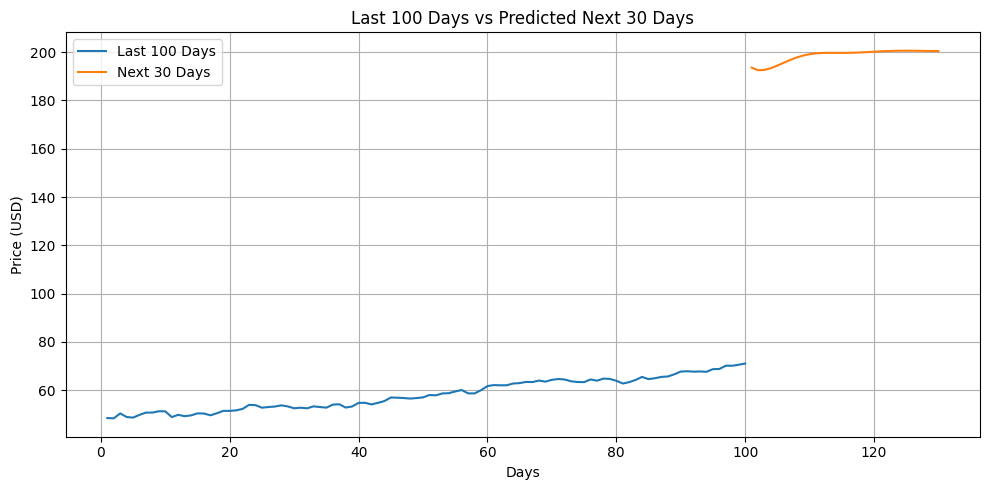

In [ ]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

plt.figure(figsize=(10, 5))
plt.plot(day_new, scaler.inverse_transform(data[1158:1158 + len(day_new)]),
         label='Last 100 Days')
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)),
         label='Next 30 Days')
plt.title("Last 100 Days vs Predicted Next 30 Days")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


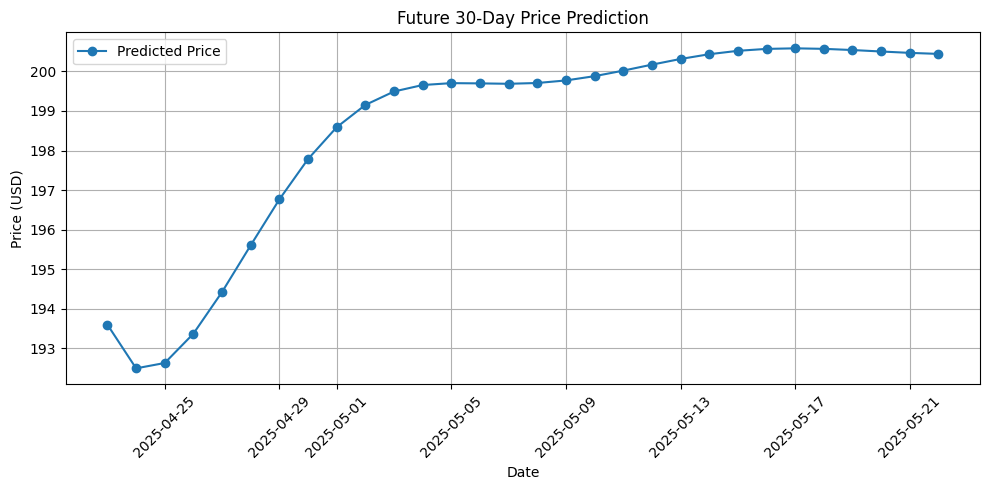

In [ ]:
import datetime
future_dates = [datetime.date.today() + datetime.timedelta(days=i)
for i in range(1, 31)]

plt.figure(figsize=(10, 5))
plt.plot(future_dates,
scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), marker='o',
label="Predicted Price")
plt.title("Future 30-Day Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
last_rsi = RSIIndicator(close=pd.Series(test_predict.flatten())).rsi().iloc[-1]
last_price = scaler.inverse_transform([test_data[-1]])[0][0]
predicted_price = test_predict[-1][0]

def trading_signal(last_price, predicted_price, rsi):
    if rsi < 30 and predicted_price > last_price:
        return "Buy"
    elif rsi > 70 and predicted_price < last_price:
        return "Sell"
    else:
        return "Hold"

signal = trading_signal(last_price, predicted_price, last_rsi)
print(f"Last Price: {last_price:.2f}, Predicted Price: {predicted_price:.2f},
RSI: {last_rsi:.2f}")
print(f"Suggested Action: {signal}")


Last Price: 193.16, Predicted Price: 201.59, RSI: 41.65
Suggested Action: Hold


In [ ]:


# Convert scaled test data & predictions back to real prices
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred = test_predict.flatten()

# Create classification labels (Up=1, Down=0)
true_directions = np.array(y_test_true[1:] > y_test_true[:-1], dtype=int)
predicted_directions = np.array(y_test_pred[1:] > y_test_pred[:-1], dtype=int)

# Evaluation Function
def evaluate_model(y_true_prices, y_pred_prices, y_true_directions,
                   y_pred_directions):
    min_len = min(len(y_true_prices), len(y_pred_prices),
                  len(y_true_directions), len(y_pred_directions))
    y_true_prices = y_true_prices[:min_len]
    y_pred_prices = y_pred_prices[:min_len]
    y_true_directions = y_true_directions[:min_len]
    y_pred_directions = y_pred_directions[:min_len]

    # Regression
    mse = mean_squared_error(y_true_prices, y_pred_prices)
    mae = mean_absolute_error(y_true_prices, y_pred_prices)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_prices, y_pred_prices)

    # Classification
    accuracy = accuracy_score(y_true_directions, y_pred_directions)
    precision = precision_score(y_true_directions, y_pred_directions)
    recall = recall_score(y_true_directions, y_pred_directions)
    f1 = f1_score(y_true_directions, y_pred_directions)

    print("\n📊 Evaluation Summary")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    return accuracy, precision, recall, f1

# 4️⃣ Evaluate
evaluate_model(
    y_true_prices=y_test_true[1:],
    y_pred_prices=y_test_pred[1:],
    y_true_directions=true_directions,
    y_pred_directions=predicted_directions
)





📊 Evaluation Summary
RMSE: 4.14
MAE: 3.07
R² Score: 0.98
Accuracy: 51.06%
Precision: 53.67%
Recall: 54.93%
F1 Score: 54.29%


(0.5105590062111801, 0.536697247706422, 0.5492957746478874, 0.54292343387471)

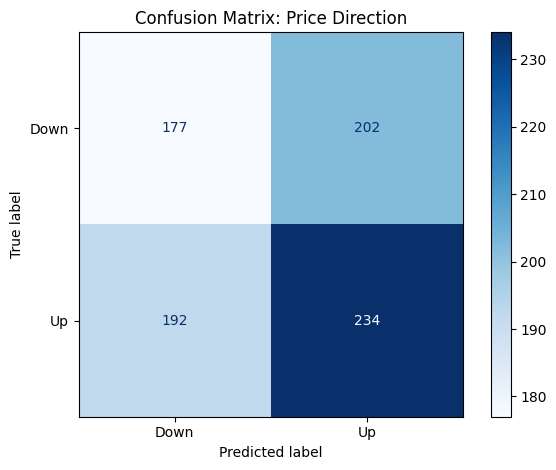

In [ ]:
cm = confusion_matrix(true_directions, predicted_directions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Down", "Up"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Price Direction")
plt.grid(False)
plt.tight_layout()
plt.show()
